# Flatiron Capstone Project – Notebook #2: Preprocessing

Student name: **Angelo Turri**

Student pace: **self paced**

Project finish date: **1/19/24**

Instructor name: **Mark Barbour**

# Instructions

Due to the size of this project, there are four notebooks instead of one. The proper order to execute these notebooks is as follows:

- **Gathering Data**
- **Preprocessing** <---- You are here
- **Feature Engineering**
- **Modeling**

# Preprocessing Steps

### Removing hyperlinks and extraneous characters

- I used a regex to eliminate hyperlinks. The regex wasn't perfect, but it was very good. It reduced the number of posts with hyperlinks from 108,228 to just 229. That's a 99.8% reduction in posts with hyperlinks.
- There were several other combinations of characters we replaced, such as "&gt;" that repeated many times. These are longhand notations of certain special characters like ">" or "<". They can be looked up [on this website](https://www.htmlhelp.com/reference/html40/entities/special.html).

### Tokenizing posts
- Tokenizing strings is the process of separating them into lists, where each element is an individual word in that sring. I used another regex that identified words and eliminated special characters such as punctuation.
- Tokenization enables easy stopword removal and the creation of bigrams and trigrams.

### Stopword removal
- Stopwords are commonly used words that significantly increase the burden on models while contributing very little. We removed stopwords contained in nltk's stopword list. This resulted in the removal of 22.3 million words, about half of all original words.

### Calculating post lengths
- Enables the removal of insanely long posts and create more reasonably distributed data.

### Creating bigrams and trigrams
- Individual words are one means of extracting insights from this data, but bigrams and trigrams carry more information that individual words. By extracting bigrams and trigrams, we have two more options for analysis and the potential to give more meaningful recommendations to our stakeholder.

### Removing bots
- All posts from the universal reddit moderator, AutoModerator, were removed.
- Posts with the words "bot made by u/reddit_username" were removed.
- Authors with the word "bot" or "Bot" in their name were removed.
- Posts with the words "I'm a bot" were removed.

These measures weren't perfect - they probably didn't remove all the bots, and they did remove some posts by real people. However, the vast majority of posts removed by these measures were made by bots.

If you're skeptical about the effectiveness of these measures, or you think they might have been too extensive, head to the Appendix at the end of this notebook. It shows you the kinds of posts each measure removed. These queries take up quite a bit of space, which is why I kept them at the end of the notebook.

### Capping post length at 200 words
- Looking at the distribution of post length, it was extremely skewed to the right. Capping post length at 200 words results in a much more reasonable distribution.

### Giving post score a hard boundary of (-25, 100)
- Looking at the distribution of post scores, it had long tails to both the right and left. A lower boundary of -25 and an upper boundary of 100 returned the distribution to a more reasonable state.

### Spam removal
- Removing posts longer than 200 words eliminated some spam, but not all.
- I used the most common unigrams, bigrams, and trigrams to locate any other spam.
    - Posts containing a unigram four or more times in a row were removed.
    - Posts containing a bigram three or more times in a row were removed.
    - Posts containing a trigram two or more times in a row were removed.
- Even after all these measures, trigrams such as "source script protect" continued to appear in the most common phrases. I manually removed these.
- All combined spam from this notebook is stored externally in a single dataframe, "spam.parquet."

# Importing Packages

In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

from IPython.display import clear_output, display_html, Markdown, display
import time
from tqdm.notebook import tqdm
tqdm.pandas()

import re

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk import word_tokenize
from  nltk import FreqDist
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tag.perceptron import PerceptronTagger

import warnings
warnings.filterwarnings('ignore')

In [4]:
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)
stopwords_list += ['``', "''", "’", "“", "”"]
stopwords_list = set(stopwords_list)

NameError: name 'string' is not defined

In [1]:
stopwords_list

NameError: name 'stopwords_list' is not defined

# Importing data

In [9]:
name = 'the_donald_comments'
df = pd.read_parquet(path=f'data/stored/{name}.parquet')

# Removing hyperlinks and extraneous characters

I use a hyperlink regex provided [here](https://stackoverflow.com/questions/6038061/regular-expression-to-find-urls-within-a-string) to find and replace hyperlinks in my data. Initially, there were 32,000 posts with hyperlinks, and after using this regex, only 91 remained. The regex wasn't perfect, but it was extremely effective, successfully removing all hyperlinks from 99.97% of posts that originally had them.

In [10]:
hyperlink_regex = '(http|ftp|https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w@?^=%&\/~+#-])'
len_before = len(df[df.post.str.contains('http')])
print(f"Number of posts with hyperlinks: {len_before}")

Number of posts with hyperlinks: 108228


In [11]:
to_replace = [hyperlink_regex, "&gt;", "&lt;", "\n", "&amp;", "#x200B;"]

def remove_hyperlink(text):
    for string in to_replace:
        text = re.sub(string, " ", text)
    return text

In [12]:
df['hyperlinks_removed'] = df['post'].progress_apply(remove_hyperlink)

  0%|          | 0/1894969 [00:00<?, ?it/s]

In [13]:
len(df[df.hyperlinks_removed.str.contains('http')])

229

# Tokenizing posts

Tokenizing a string turns into a list, where each element is one of the words in the original string. Tokenizing enables easy stopword removal, and the creation of bigrams/trigrams.

In [14]:
WORD = re.compile(r'\w+')
df['tokenized'] = df['hyperlinks_removed'].progress_apply(lambda x: WORD.findall(x))

  0%|          | 0/1894969 [00:00<?, ?it/s]

In [15]:
# Lowercasing words will enable us to create accurate word counts.
# If we don't lowercase words, then the word "Fish" will be treated differently from the word "fish,"
# which shouldn't happen.


# It will also enable us to remove stopwords; our list of stopwords is all in lowercase.

df['lowercase'] = df['tokenized'].progress_apply(lambda x: [w.lower() for w in x])

  0%|          | 0/1894969 [00:00<?, ?it/s]

# Removing stopwords

Stopwords don't contribute very much to models despite making up a huge chunk of text. They should be removed to improve performance. In total, about half of all the original words were removed. This takes a huge workload off of our models.

In [16]:
df['stopwords_removed'] = df['lowercase'].progress_apply(lambda x: [w for w in x if w not in stopwords_list])
df['joined'] = df['stopwords_removed'].str.join(" ")

  0%|          | 0/1894969 [00:00<?, ?it/s]

In [17]:
num_words_after = len(df['stopwords_removed'].explode())
num_words_before = len(df['tokenized'].explode())

total_stopwords_removed = num_words_before - num_words_after
percentage_words_removed = total_stopwords_removed / num_words_before

In [18]:
print(f"A total of {total_stopwords_removed:,} stopwords were removed, \
which is {percentage_words_removed:.2%} of all original words.")

A total of 22,372,164 stopwords were removed, which is 48.42% of all original words.


# Calculating post lengths

This enables us to set a cutoff point for allowed post lengths, and it will also provide helpful visualizations.

In [19]:
df['lengths'] = df.tokenized.str.len()

# Creating bigrams and trigrams

Bigrams and trigrams are more meaningful units than words that can be helpful when we feature engineer for models.

We use tuples instead of lists because tuples are hashable types, which enables us to use functions like **Counter()** in the **collections** library to perform counts on the bigrams & trigrams.

In [20]:
df['bigrams'] = df['stopwords_removed'].progress_apply(lambda x: [tuple([x[i], x[i+1]]) for i in range(len(x)-1)])
df['trigrams'] = df['stopwords_removed'].progress_apply(lambda x: [tuple([x[i], x[i+1], x[i+2]]) for i in range(len(x)-2)])

  0%|          | 0/1894969 [00:00<?, ?it/s]

  0%|          | 0/1894969 [00:00<?, ?it/s]

# Removing bots

In [21]:
# Removing posts by the universal reddit bot, AutoModerator
mask = df.author=='AutoModerator'
auto_moderator_spam = df[mask]
df = df[~mask]

In [22]:
# Removing bots with the bot signature "bot by u/*reddit_username*"
mask = df.joined.str.contains(' bot u ')
bot_signature_spam = df[mask]
df = df[~mask]

In [23]:
# Removing bots with the word "bot" in their name
bot_names = list(df[(df.author.str.contains('bot')) | (df.author.str.contains('Bot'))].author.value_counts().index)
mask = df.author.isin(bot_names)
bot_name_spam = df[mask]
df = df[~mask]

In [24]:
# Removing authors whose posts contain "I'm a bot"
im_a_bot = list(df[df.post.str.contains("I'm a bot")].author.value_counts().index)
mask = df.post.str.contains("I'm a bot")
im_a_bot_spam = df[mask]
df = df[~mask]

# Capping post length at 200 words

This fixes a very skewed length distribution that seems to have major outliers.

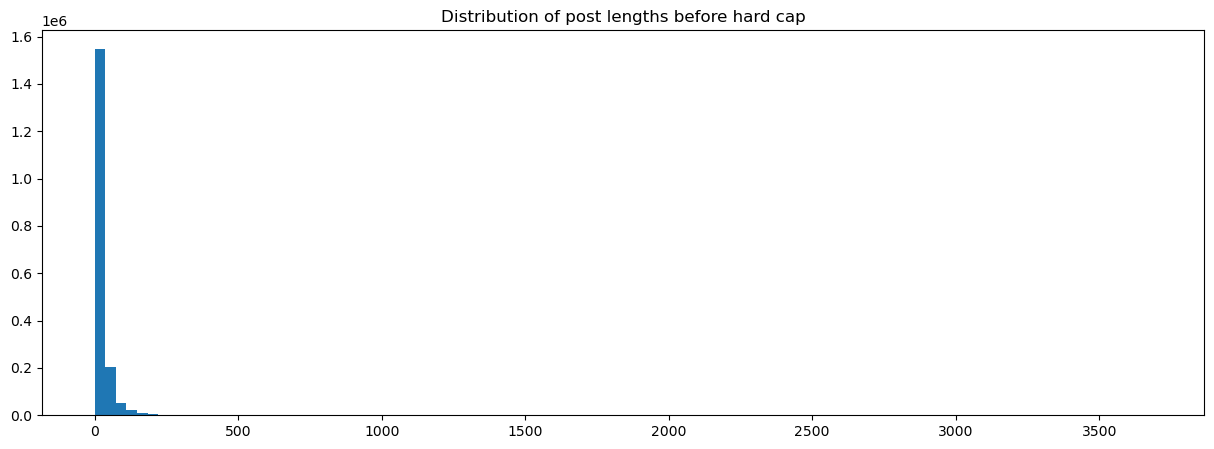

In [25]:
fig, ax = plt.subplots(figsize=(15,5))
ax.hist(df.lengths, bins=100)
ax.set_title("Distribution of post lengths before hard cap");

In [26]:
mask = df.lengths>200
large_posts = df[mask]

df = df[~mask]

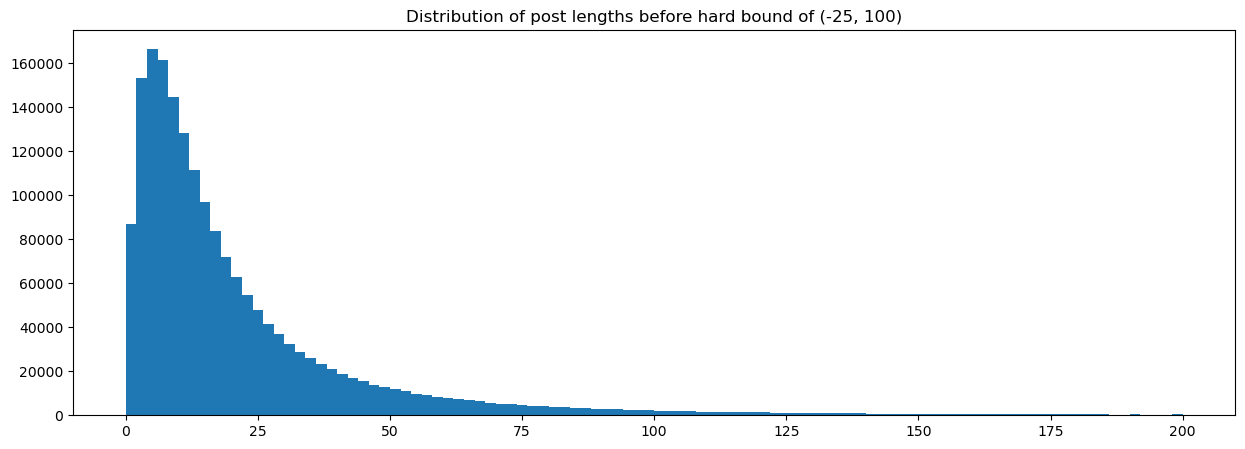

In [27]:
fig, ax = plt.subplots(figsize=(15,5))
ax.hist(df.lengths, bins=100);
ax.set_title("Distribution of post lengths before hard cap of 200");

# Bounding post score at (-25, 100)

This fixes a very skewed score distribution that seems to have major outliers at both ends.

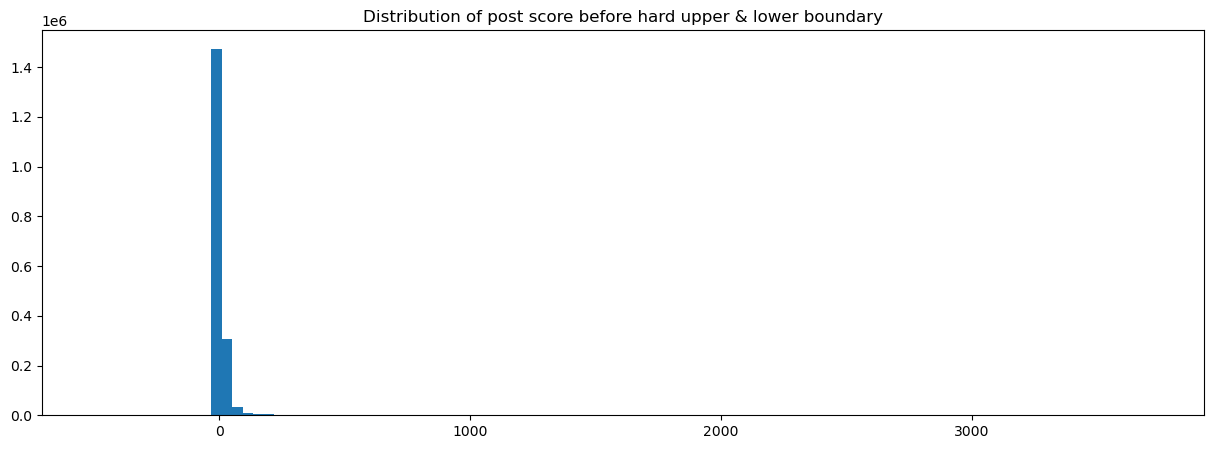

In [28]:
fig, ax = plt.subplots(figsize=(15,5))
ax.hist(df.score, bins=100)
ax.set_title("Distribution of post score before hard upper & lower boundary");

In [38]:
df.score.min(), df.score.max()

(-496, 3716)

In [40]:
mask = (df.score>100) | (df.score<-25)
extreme_scores = df[mask]

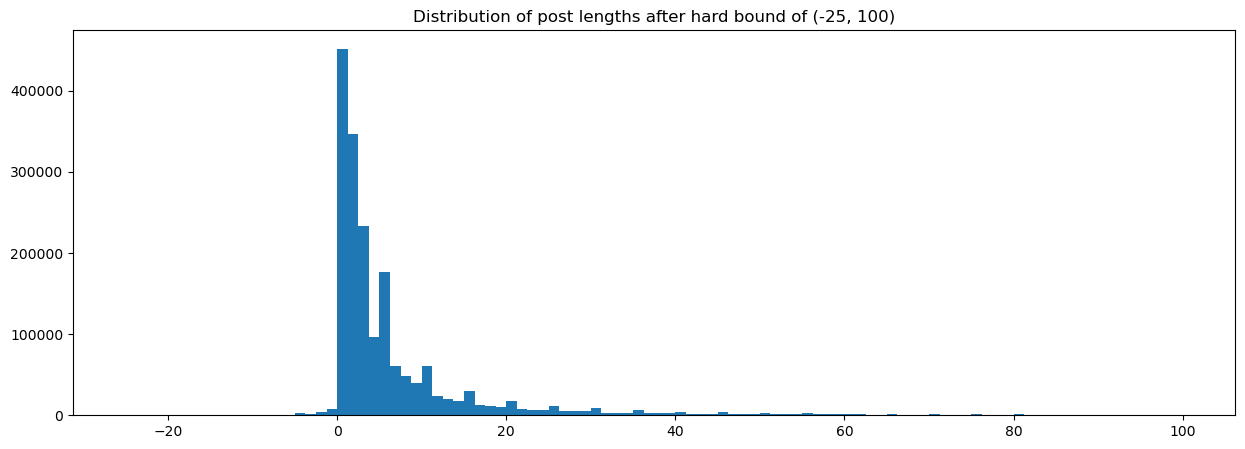

In [45]:
fig, ax = plt.subplots(figsize=(15,5))
ax.hist(df[~mask].score, bins=100);
ax.set_title("Distribution of post lengths after hard bound of (-25, 100)");

# Investigating for spam

We want to remove posts that have many duplicate strings, to avoid skewing our models.

- Remove four or more consecutive instances of a unigram
- Remove three or more consecutive instances of a bigram
- Remove two or more consecutive instances of a trigram

In [24]:
all_unigrams = df.stopwords_removed.explode()
all_bigrams = df.bigrams.explode()
all_trigrams = df.trigrams.explode()

unigrams = Counter(all_unigrams)
bigrams = Counter(all_bigrams)
trigrams = Counter(all_trigrams)

In [25]:
most_common_unigrams = unigrams.most_common(150)
spam_strings = []

for unigram, count in most_common_unigrams:
    
    spam_string = ' '.join([unigram]*4)
    spam_strings.append(spam_string)
    
spam_strings = '|'.join(spam_strings)
mask = df.joined.str.contains(spam_strings)
unigram_spam = df[mask]
df = df[~mask]

In [26]:
most_common_bigrams = bigrams.most_common(150)
spam_strings = []

for bigram, count in most_common_bigrams:
    
    bigram = ' '.join(bigram)
    spam_string = ' '.join([bigram]*3)
    spam_strings.append(spam_string)
    
spam_strings = '|'.join(spam_strings)
mask = df.joined.str.contains(spam_strings)
bigram_spam = df[mask]
df = df[~mask]

In [27]:
most_common_trigrams = trigrams.most_common(150)
spam_strings = []

for trigram, count in most_common_trigrams:
    
    trigram = ' '.join(trigram)
    spam_string = ' '.join([trigram]*2)
    spam_strings.append(spam_string)
    
spam_strings = '|'.join(spam_strings)
mask = df.joined.str.contains(spam_strings)
trigram_spam = df[mask]
df = df[~mask]

In [28]:
mask = df.joined.str.contains('source script protect')
script_spam = df[mask]
df = df[~mask]

# Storing data externally

In [ ]:
# Storing preprocessed dataframe
df.to_parquet(path=f'data/stored/{name}_preprocessed.parquet')

In [91]:
#Storing spam
spams = [auto_moderator_spam, 
         bot_signature_spam, 
         bot_name_spam, 
         im_a_bot_spam, 
         unigram_spam, 
         bigram_spam, 
         trigram_spam, 
         script_spam, 
         large_posts]

spam = pd.concat(spams)
spam.to_parquet(path=f'data/stored/{name}_spam.parquet')

In [30]:
# Re-calculating word counts for feature engineering
all_unigrams = df.stopwords_removed.explode()
all_bigrams = df.bigrams.explode()
all_trigrams = df.trigrams.explode()

unigrams = Counter(all_unigrams)
bigrams = Counter(all_bigrams)
trigrams = Counter(all_trigrams)

In [94]:
pd.DataFrame({'unigram': [x[0] for x in unigrams.most_common(1000)], 
              'count': [x[1] for x in unigrams.most_common(1000)]})\
            .sort_values(by='count', ascending=False)\
            .to_parquet(path=f'data/stored/grams/{name}_unigrams.parquet')

In [95]:
pd.DataFrame({'bigram': [x[0] for x in bigrams.most_common(1000)], 
              'count': [x[1] for x in bigrams.most_common(1000)]})\
            .sort_values(by='count', ascending=False)\
            .to_parquet(path=f'data/stored/grams/{name}_bigrams.parquet')

In [96]:
pd.DataFrame({'trigram': [x[0] for x in trigrams.most_common(1000)], 
              'count': [x[1] for x in trigrams.most_common(1000)]})\
            .sort_values(by='count', ascending=False)\
            .to_parquet(path=f'data/stored/grams/{name}_trigrams.parquet')

# Appendix

In [93]:
# Example of spam
spam[spam.joined.str.contains('isis isis isis')].post.iloc[0]

'ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS ISIS

In [ ]:
# What AutoModerator's posts look like
auto_moderator_spam.head()

In [ ]:
# I decided to remove posts that had "bot u" after stopwords had been removed.
# I took this to mean that there was originally a "bot by u/reddit_username"
# at the end of the post, meaning the post was made by a bot.
# These are the posts that got removed due to this measure.

for bot in bot_signature_spam.author.unique():
    bot_posts = bot_signature_spam[bot_signature_spam.author==bot][['post']]
    display(bot_posts.head().style.set_caption(f"Author: {bot}, number of posts: {len(bot_posts)}"))
    print('\n\n')

In [ ]:
# I decided to remove all posts made by authors with "bot" or "Bot" in their names.
# Not all authors with a name like this were actually bots, but they were infested with bots.
# Being that these posts were already a small part of the existing posts, it was not worth
# manually finding all the actual bots.
# These are the posts that got removed due to this measure.

for bot in bot_name_spam.author.value_counts().index:
    bot_posts = bot_name_spam[bot_name_spam.author==bot][['post']]
    display(bot_posts.head().style.set_caption(f"Author: {bot}, number of posts: {len(bot_posts)}"))
    print('\n\n')

In [ ]:
# I decided to remove all posts that contained the text "I'm a bot".
# Not all were made by bots, but most were.

for bot in im_a_bot_spam.author.value_counts().index:
    bot_posts = im_a_bot_spam[im_a_bot_spam.author==bot][['post']]
    display(bot_posts.head().style.set_caption(f"Author: {bot}, number of posts: {len(bot_posts)}"))
    print('\n\n')

In [2]:
script_spam

NameError: name 'script_spam' is not defined